In [11]:
import numpy as np
from astropy.io import fits
import healpy as hp
import pandas as pd
import matplotlib.path as mplPath
import matplotlib.pyplot as plt

import pickle


### Retrieving the relevant CCD Data

In [2]:
decamCCD = fits.open('../bricks_data/ccds-annotated-decam-dr9.fits')
#mosaicCCD = fits.open('../bricks_data/ccds-annotated-mosaic-dr9.fits')
#bassCCD = fits.open('../bricks_data/ccds-annotated-90prime-dr9.fits')
print(decamCCD[1].columns)


ColDefs(
    name = 'image_filename'; format = '120A'
    name = 'image_hdu'; format = 'I'
    name = 'camera'; format = '5A'
    name = 'expnum'; format = 'K'
    name = 'plver'; format = '8A'
    name = 'procdate'; format = '19A'
    name = 'plprocid'; format = '7A'
    name = 'ccdname'; format = '3A'
    name = 'object'; format = '35A'
    name = 'propid'; format = '10A'
    name = 'filter'; format = '1A'
    name = 'exptime'; format = 'E'
    name = 'mjd_obs'; format = 'D'
    name = 'airmass'; format = 'E'
    name = 'fwhm'; format = 'E'
    name = 'width'; format = 'I'
    name = 'height'; format = 'I'
    name = 'ra_bore'; format = 'D'
    name = 'dec_bore'; format = 'D'
    name = 'crpix1'; format = 'E'
    name = 'crpix2'; format = 'E'
    name = 'crval1'; format = 'D'
    name = 'crval2'; format = 'D'
    name = 'cd1_1'; format = 'E'
    name = 'cd1_2'; format = 'E'
    name = 'cd2_1'; format = 'E'
    name = 'cd2_2'; format = 'E'
    name = 'yshift'; format = 'L'
    name = 

In [3]:
dataDecam = decamCCD[1].data
#dataMosaic = mosaicCCD[1].data
#dataBass = bassCCD[1].data

In [14]:
ra0 = dataDecam.field('ra0')
dec0 = dataDecam.field('dec0')
ra1 = dataDecam.field('ra1')
dec1 = dataDecam.field('dec1')
ra2 = dataDecam.field('ra2')
dec2 = dataDecam.field('dec2')
ra3 = dataDecam.field('ra3')
dec3 = dataDecam.field('dec3')
#Extracting First systematic
filter = dataDecam.field('filter')

airmass = dataDecam.field('airmass')

In [5]:
df = pd.read_csv('../bricks_data/galaxy_catalogue_sample.csv')

ra = df["RA"].to_numpy(copy=True)
dec = df["DEC"].to_numpy(copy=True)

raDec = np.stack((ra,dec), axis=1)

print(raDec.shape)

def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))

NSIDE = 256
NPIX = hp.nside2npix(NSIDE)


(379416, 2)


### Now, trying to actually get all ccds per pixel
Begin by loading the Dictionary mapping pixels to CCDs. Afterwards, iterating through the ccds for a given pixel.
Depending on the systematics, we have to break systematics down into the different bands.
Airmass is simply averaged across all CCDs, exposure times are calculated on a per CCD basis.


In [7]:
with open('../bricks_data/brickpixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

z
r
g


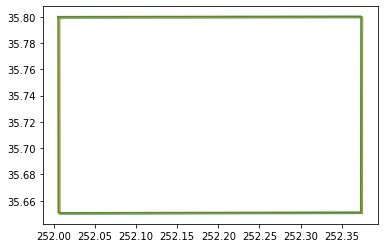

In [16]:
ccds_per_pixel = pixel2ccd_dict[163021]

for ccd in ccds_per_pixel:
    #coord = [[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]
        xs = [ra0[ccd],ra1[ccd], ra2[ccd], ra3[ccd],ra0[ccd] ]
        ys = [dec0[ccd],dec1[ccd], dec2[ccd], dec3[ccd],dec0[ccd]]
        print(filter[ccd])
        plt.plot(xs,ys)


#### Classifying whether a given galaxy is inside one of the CCDs in a pixel

In [ ]:
# Identifying which CCD features a given Galaxy
# Looping through CCDs

for no in range(len(ra0)):

    x0 = ra0[no]
    x1 = ra1[no]
    x2 = ra2[no]
    x3 = ra3[no]

    y0 = dec0[no]
    y1 = dec1[no]
    y2 = dec2[no]
    y3 = dec3[no]

    #Define a Bounding Box using the coorners of a CCD

    boundingBoxPath = mplPath.Path(np.array([[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]))


    # Check how many of the Objects in my galaxy catalogue are in that bounding box
    no_objects_in_ccd = boundingBoxPath.contains_points(raDec).sum()
    if no_objects_in_ccd > 0:
        print(no, no_objects_in_ccd)
